# Hybrid Recommendation System For Netflix 2023 Dataset

This notebook implements a hybrid recommendation system that combines:
1. **Content-based filtering** using deep embeddings
2. **Collaborative filtering** using popularity and behavioral patterns
3. **Advanced preprocessing** and feature engineering


In [1]:
## Setup and Installation
!pip install pandas numpy matplotlib scikit-learn
!pip install tensorflow==2.15.0

In [2]:
## Import Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

# For Google Colab
try:
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False


In [ ]:
import sys
import tensorflow.keras.backend as K
import tensorflow.keras

# Diagnostic Cell - Check TensorFlow Version and Environment
print("=== ENVIRONMENT DIAGNOSIS ===")
print(f"TensorFlow version: {tf.__version__}")
import keras
print(f"Keras version: {keras.__version__}")
print(f"Python version: {sys.version}")


print(f"Keras backend: {K.backend()}")

# Check if we're in Colab
if 'google.colab' in sys.modules:
    print("Environment: Google Colab")
else:
    print("Environment: Local/Other")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs available: {len(gpus)}")

=== ENVIRONMENT DIAGNOSIS ===
TensorFlow version: 2.15.0
Keras version: 2.15.0
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Keras backend: tensorflow
Environment: Google Colab
GPUs available: 0


In [4]:
## Data Loading and Upload
# Upload data files
if IN_COLAB:
    print("Please upload your Netflix dataset files:")
    print("1. Raw Netflix content CSV")
    print("2. Processed Netflix CSV (optional)")
    print("3. Features matrix CSV (optional)")
    uploaded = files.upload()

    # Identify the raw dataset file
    raw_filename = None
    for filename in uploaded.keys():
        if 'netflix' in filename.lower() and 'content' in filename.lower():
            raw_filename = filename
            break

    if not raw_filename:
        raw_filename = list(uploaded.keys())[0]  # Use first uploaded file

    print(f"Using '{raw_filename}' as the raw dataset")
else:
    # For local environment - adjust paths as needed
    raw_filename = 'netflix_content.csv'
    print(f"Looking for local file: {raw_filename}")

print("Data upload/detection completed!")

Please upload your Netflix dataset files:
1. Raw Netflix content CSV
2. Processed Netflix CSV (optional)
3. Features matrix CSV (optional)


Saving netflix_content.csv to netflix_content.csv
Using 'netflix_content.csv' as the raw dataset
Data upload/detection completed!


In [5]:
## Data Loading and Comprehensive Preprocessing
def load_and_preprocess_data(raw_filename):
    """
    Load and comprehensively preprocess the Netflix dataset
    """
    print("Loading and preprocessing data...")

    # Load raw dataset
    df_raw = pd.read_csv(raw_filename)
    print(f"Raw dataset loaded: {df_raw.shape}")
    print(f"Columns: {df_raw.columns.tolist()}")

    # Display first few rows
    print("\nFirst 3 rows:")
    print(df_raw.head(3))

    # Clean Hours Viewed (remove commas and convert to numeric)
    print("\nCleaning Hours Viewed data...")
    df_raw['Hours Viewed Clean'] = df_raw['Hours Viewed'].astype(str).str.replace(',', '').str.replace(' ', '')
    df_raw['Hours Viewed Clean'] = pd.to_numeric(df_raw['Hours Viewed Clean'], errors='coerce')

    print(f"Hours Viewed - Before: {df_raw['Hours Viewed'].iloc[0]}")
    print(f"Hours Viewed - After: {df_raw['Hours Viewed Clean'].iloc[0]}")

    # Handle missing release dates
    missing_dates = df_raw['Release Date'].isnull().sum()
    print(f"\nMissing release dates: {missing_dates} ({missing_dates/len(df_raw)*100:.1f}%)")

    # For missing dates, assign a default year and estimate based on content patterns
    current_year = 2023
    df_raw['Release Date'] = df_raw['Release Date'].fillna('2020-01-01')

    # Parse release dates
    df_raw['Release Date'] = pd.to_datetime(df_raw['Release Date'], errors='coerce')
    df_raw['Release Year'] = df_raw['Release Date'].dt.year
    df_raw['Release Month'] = df_raw['Release Date'].dt.month

    # Calculate content age (years since release)
    df_raw['Content Age'] = current_year - df_raw['Release Year']
    df_raw['Content Age'] = df_raw['Content Age'].clip(lower=0)  # Ensure non-negative

    # Create binary features
    df_raw['Is Global'] = (df_raw['Available Globally?'] == 'Yes').astype(int)

    # Drop rows with missing critical data
    print(f"\nBefore cleaning: {len(df_raw)} rows")
    df_raw.dropna(subset=['Title', 'Hours Viewed Clean'], inplace=True)
    df_raw.drop_duplicates(subset=['Title'], inplace=True)
    print(f"After cleaning: {len(df_raw)} rows")

    # Reset index and create Title ID
    df_raw = df_raw.reset_index(drop=True)
    df_raw['Title ID'] = df_raw.index

    return df_raw

# Load and preprocess the data
df = load_and_preprocess_data(raw_filename)

print("\n=== DATA OVERVIEW AFTER INITIAL PREPROCESSING ===")
print(f"Dataset shape: {df.shape}")
print(f"Languages: {df['Language Indicator'].unique()}")
print(f"Content Types: {df['Content Type'].unique()}")
print(f"Years range: {df['Release Year'].min()} - {df['Release Year'].max()}")

Loading and preprocessing data...
Raw dataset loaded: (24812, 6)
Columns: ['Title', 'Available Globally?', 'Release Date', 'Hours Viewed', 'Language Indicator', 'Content Type']

First 3 rows:
                                Title Available Globally? Release Date  \
0           The Night Agent: Season 1                 Yes   2023-03-23   
1           Ginny & Georgia: Season 2                 Yes   2023-01-05   
2  The Glory: Season 1 // 더 글로리: 시즌 1                 Yes   2022-12-30   

   Hours Viewed Language Indicator Content Type  
0  81,21,00,000            English         Show  
1  66,51,00,000            English         Show  
2  62,28,00,000             Korean         Show  

Cleaning Hours Viewed data...
Hours Viewed - Before: 81,21,00,000
Hours Viewed - After: 812100000

Missing release dates: 16646 (67.1%)

Before cleaning: 24812 rows
After cleaning: 19158 rows

=== DATA OVERVIEW AFTER INITIAL PREPROCESSING ===
Dataset shape: (19158, 12)
Languages: ['English' 'Korean' 'Non-Engl

In [6]:
## Advanced Feature Engineering
def create_advanced_features(df):
    """
    Create advanced features for better recommendations
    """
    print("Creating advanced features...")

    # Encode categorical variables
    le_language = LabelEncoder()
    le_content_type = LabelEncoder()

    df['Language Code'] = le_language.fit_transform(df['Language Indicator'])
    df['Content Type Code'] = le_content_type.fit_transform(df['Content Type'])

    # Normalize Hours Viewed for training
    scaler = StandardScaler()
    df['Hours Viewed Normalized'] = scaler.fit_transform(df[['Hours Viewed Clean']])

    # Create popularity score (combining hours viewed and recency)
    max_hours = df['Hours Viewed Clean'].max()
    df['Popularity Score'] = (
        0.7 * (df['Hours Viewed Clean'] / max_hours) +
        0.3 * (1 / (df['Content Age'] + 1))  # More recent = higher score
    )

    # Language popularity (how popular is content in each language)
    lang_popularity = df.groupby('Language Code')['Hours Viewed Clean'].mean().to_dict()
    df['Language Popularity'] = df['Language Code'].map(lang_popularity)

    # Content type popularity
    type_popularity = df.groupby('Content Type Code')['Hours Viewed Clean'].mean().to_dict()
    df['Type Popularity'] = df['Content Type Code'].map(type_popularity)

    # Seasonal features (month-based patterns)
    df['Release Season'] = df['Release Month'].apply(lambda x:
        0 if x in [12, 1, 2] else  # Winter
        1 if x in [3, 4, 5] else   # Spring
        2 if x in [6, 7, 8] else   # Summer
        3)                         # Fall

    # Content length category (based on typical patterns)
    df['Length Category'] = df['Content Type Code'].apply(lambda x:
        1 if x == 1 else 0)  # Assuming encoded values

    # Normalize new features
    scaler_features = StandardScaler()
    feature_cols = ['Language Popularity', 'Type Popularity']
    df[feature_cols] = scaler_features.fit_transform(df[feature_cols])

    # Save encoders
    encoders = {
        'language_encoder': le_language,
        'content_type_encoder': le_content_type,
        'scaler': scaler,
        'feature_scaler': scaler_features
    }

    print("Advanced features created!")
    print(f"\nFeature summary:")
    print(f"- Languages encoded: {len(le_language.classes_)} ({le_language.classes_})")
    print(f"- Content types encoded: {len(le_content_type.classes_)} ({le_content_type.classes_})")
    print(f"- Popularity score range: {df['Popularity Score'].min():.3f} - {df['Popularity Score'].max():.3f}")

    return df, encoders

df, encoders = create_advanced_features(df)

# Display processed data info
print("\n=== PROCESSED DATA SAMPLE ===")
display_cols = ['Title', 'Content Type', 'Language Indicator', 'Hours Viewed Clean',
                'Content Age', 'Popularity Score', 'Title ID', 'Language Code', 'Content Type Code']
print(df[display_cols].head())

Creating advanced features...
Advanced features created!

Feature summary:
- Languages encoded: 6 (['English' 'Hindi' 'Japanese' 'Korean' 'Non-English' 'Russian'])
- Content types encoded: 2 (['Movie' 'Show'])
- Popularity score range: 0.026 - 1.000

=== PROCESSED DATA SAMPLE ===
                                 Title Content Type Language Indicator  \
0            The Night Agent: Season 1         Show            English   
1            Ginny & Georgia: Season 2         Show            English   
2   The Glory: Season 1 // 더 글로리: 시즌 1         Show             Korean   
3                  Wednesday: Season 1         Show            English   
4  Queen Charlotte: A Bridgerton Story        Movie            English   

   Hours Viewed Clean  Content Age  Popularity Score  Title ID  Language Code  \
0           812100000            0          1.000000         0              0   
1           665100000            0          0.873291         1              0   
2           622800000          

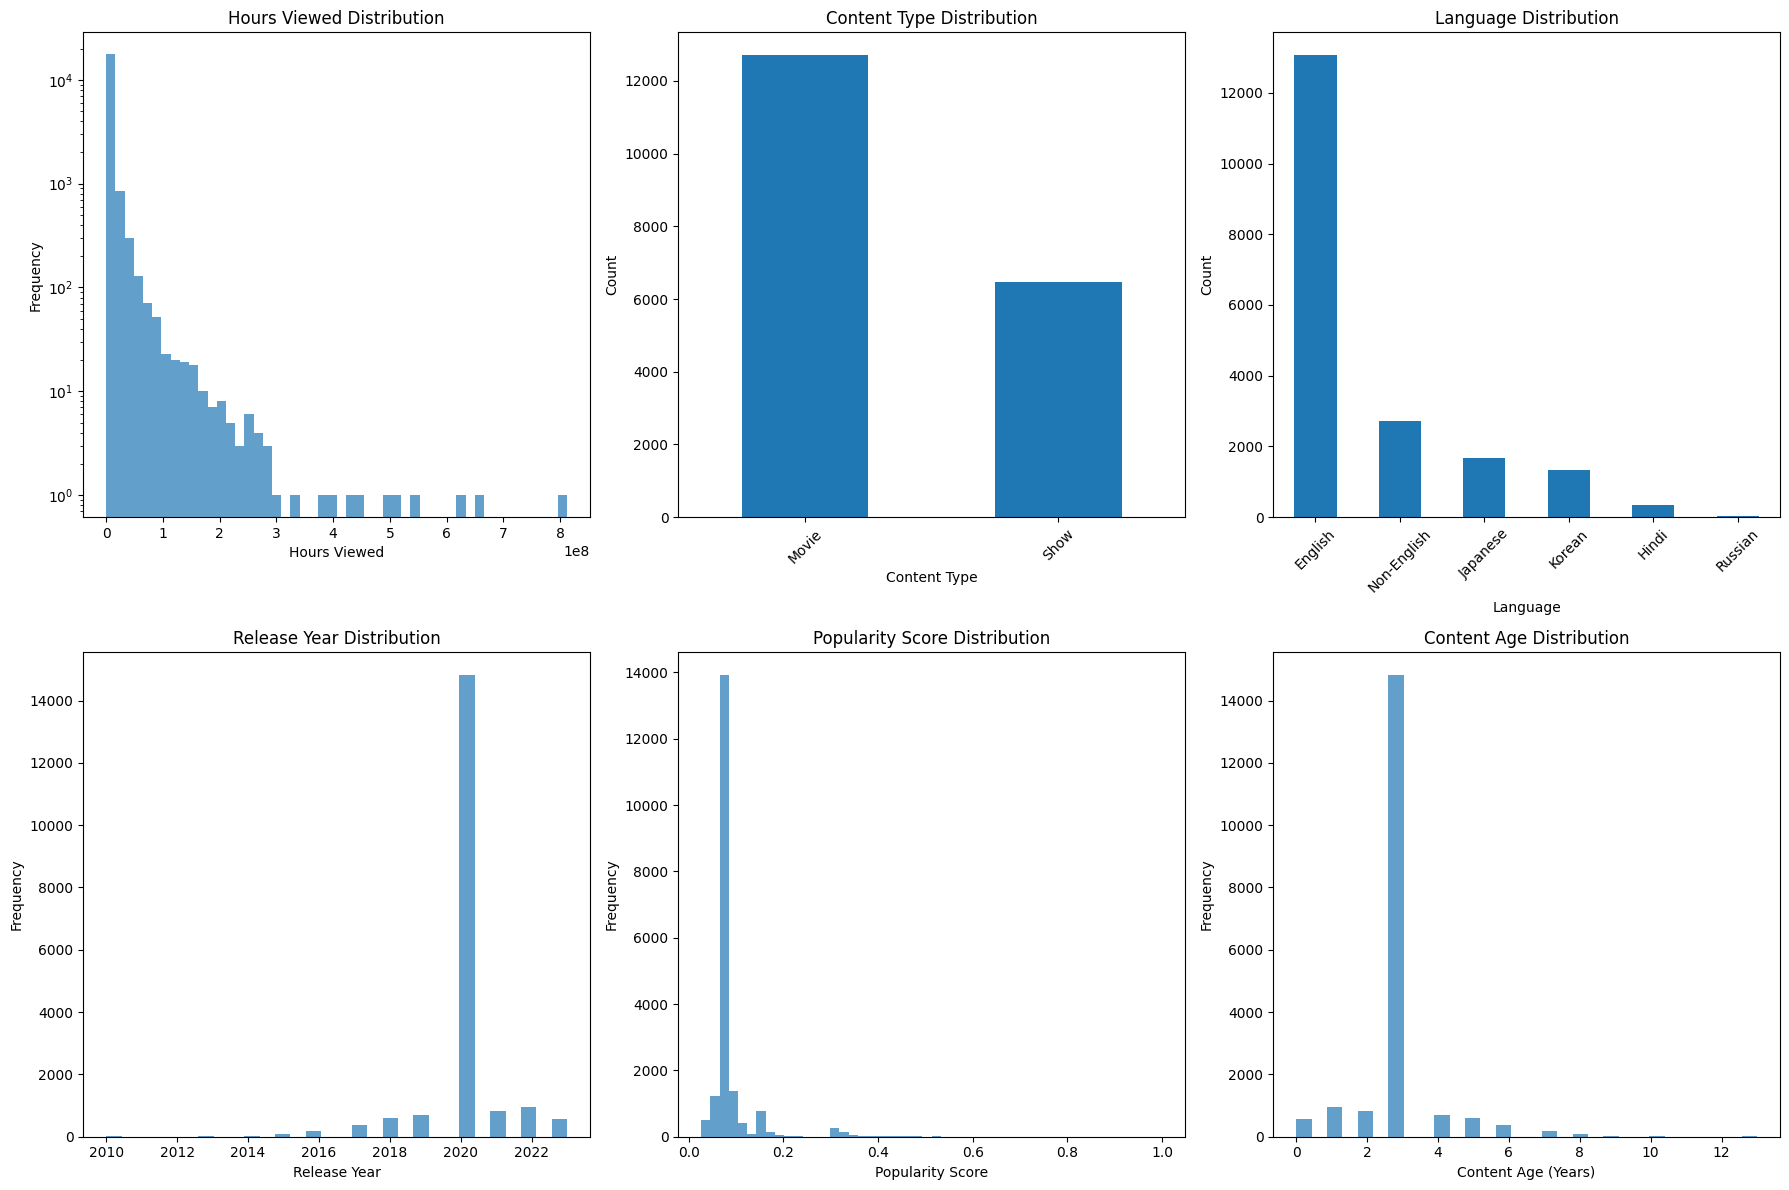


=== DATASET STATISTICS ===
Total content items: 19,158
Movies: 12,702
Shows: 6,456
Average hours viewed: 5,812,037
Median hours viewed: 800,000
Average content age: 3.0 years


In [7]:
## Data Analysis and Visualization
# Data distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Hours viewed distribution
axes[0, 0].hist(df['Hours Viewed Clean'], bins=50, alpha=0.7)
axes[0, 0].set_title('Hours Viewed Distribution')
axes[0, 0].set_xlabel('Hours Viewed')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')

# Content type distribution
df['Content Type'].value_counts().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Content Type Distribution')
axes[0, 1].set_xlabel('Content Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Language distribution
df['Language Indicator'].value_counts().plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('Language Distribution')
axes[0, 2].set_xlabel('Language')
axes[0, 2].set_ylabel('Count')
axes[0, 2].tick_params(axis='x', rotation=45)

# Release year distribution
axes[1, 0].hist(df['Release Year'], bins=30, alpha=0.7)
axes[1, 0].set_title('Release Year Distribution')
axes[1, 0].set_xlabel('Release Year')
axes[1, 0].set_ylabel('Frequency')

# Popularity score distribution
axes[1, 1].hist(df['Popularity Score'], bins=50, alpha=0.7)
axes[1, 1].set_title('Popularity Score Distribution')
axes[1, 1].set_xlabel('Popularity Score')
axes[1, 1].set_ylabel('Frequency')

# Content age distribution
axes[1, 2].hist(df['Content Age'], bins=30, alpha=0.7)
axes[1, 2].set_title('Content Age Distribution')
axes[1, 2].set_xlabel('Content Age (Years)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== DATASET STATISTICS ===")
print(f"Total content items: {len(df):,}")
print(f"Movies: {(df['Content Type'] == 'Movie').sum():,}")
print(f"Shows: {(df['Content Type'] == 'Show').sum():,}")
print(f"Average hours viewed: {df['Hours Viewed Clean'].mean():,.0f}")
print(f"Median hours viewed: {df['Hours Viewed Clean'].median():,.0f}")
print(f"Average content age: {df['Content Age'].mean():.1f} years")

In [ ]:
## Model Architecture
def build_hybrid_model(df):
    """
    Build a regularized hybrid recommendation model to prevent overfitting
    """
    print("Building regularized hybrid recommendation model...")

    # Get feature dimensions
    num_titles = df['Title ID'].nunique()
    num_languages = df['Language Code'].nunique()
    num_types = df['Content Type Code'].nunique()
    num_seasons = df['Release Season'].nunique()

    print(f"Model dimensions:")
    print(f"- Unique titles: {num_titles}")
    print(f"- Unique languages: {num_languages}")
    print(f"- Unique content types: {num_types}")
    print(f"- Unique seasons: {num_seasons}")

    from tensorflow.keras import layers, Model
    from tensorflow.keras import regularizers

    # === INPUT LAYERS ===
    title_input = layers.Input(shape=(1,), dtype='int32', name='title_id')
    language_input = layers.Input(shape=(1,), dtype='int32', name='language_id')
    type_input = layers.Input(shape=(1,), dtype='int32', name='content_type')
    season_input = layers.Input(shape=(1,), dtype='int32', name='release_season')
    numerical_input = layers.Input(shape=(6,), dtype='float32', name='numerical_features')

    # === SMALLER EMBEDDING LAYERS WITH REGULARIZATION ===
    title_embedding = layers.Embedding(
        input_dim=num_titles + 1,
        output_dim=32,  # Reduced from 64
        embeddings_regularizer=regularizers.l2(0.001),
        name='title_embedding'
    )(title_input)

    language_embedding = layers.Embedding(
        input_dim=num_languages + 1,
        output_dim=8,  # Reduced from 16
        embeddings_regularizer=regularizers.l2(0.001),
        name='language_embedding'
    )(language_input)

    type_embedding = layers.Embedding(
        input_dim=num_types + 1,
        output_dim=4,  # Reduced from 8
        embeddings_regularizer=regularizers.l2(0.001),
        name='type_embedding'
    )(type_input)

    season_embedding = layers.Embedding(
        input_dim=num_seasons + 1,
        output_dim=2,  # Reduced from 4
        embeddings_regularizer=regularizers.l2(0.001),
        name='season_embedding'
    )(season_input)

    # === FLATTEN EMBEDDINGS ===
    title_vec = layers.Flatten()(title_embedding)
    language_vec = layers.Flatten()(language_embedding)
    type_vec = layers.Flatten()(type_embedding)
    season_vec = layers.Flatten()(season_embedding)

    # === COMBINE ALL FEATURES ===
    all_features = layers.Concatenate()([
        title_vec, language_vec, type_vec, season_vec, numerical_input
    ])

    # === SMALLER DENSE LAYERS WITH MORE REGULARIZATION ===
    x = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(all_features)  # Reduced from 128
    x = layers.Dropout(0.5)(x)  # Increased from 0.3

    x = layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(x)  # Reduced from 64
    x = layers.Dropout(0.4)(x)  # Increased from 0.2

    x = layers.Dense(16, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(x)  # New smaller layer
    x = layers.Dropout(0.3)(x)

    # === OUTPUT ===
    output = layers.Dense(1, activation='sigmoid', name='popularity_prediction')(x)

    # === CREATE MODEL ===
    model = Model(
        inputs=[title_input, language_input, type_input, season_input, numerical_input],
        outputs=output
    )

    # === COMPILE WITH LOWER LEARNING RATE ===
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Reduced from 0.001
        loss='mse',
        metrics=['mae']
    )

    return model

# Build the regularized model
model = build_hybrid_model(df)
model.summary()

Building regularized hybrid recommendation model...
Model dimensions:
- Unique titles: 19158
- Unique languages: 6
- Unique content types: 2
- Unique seasons: 4
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title_id (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 language_id (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 content_type (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 release_season (InputLayer  [

In [15]:
## Data Preparation for Training
def prepare_training_data(df):
    """
    Prepare training data for the hybrid model - Fixed for TF 2.15.0
    """
    print("Preparing training data...")

    # Features with proper data types
    X = {
        'title_id': df['Title ID'].values.astype(np.int32),
        'language_id': df['Language Code'].values.astype(np.int32),
        'content_type': df['Content Type Code'].values.astype(np.int32),
        'release_season': df['Release Season'].values.astype(np.int32),
        'numerical_features': df[['Content Age', 'Is Global', 'Popularity Score',
                                  'Language Popularity', 'Type Popularity', 'Length Category']].values.astype(np.float32)
    }

    # Single target - popularity score
    y = df['Popularity Score'].values.astype(np.float32)

    # Split data
    indices = np.arange(len(df))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42,
                                         stratify=df['Content Type Code'])

    X_train = {key: val[train_idx] for key, val in X.items()}
    X_val = {key: val[val_idx] for key, val in X.items()}

    y_train = y[train_idx]
    y_val = y[val_idx]

    print(f"Training samples: {len(train_idx):,}")
    print(f"Validation samples: {len(val_idx):,}")

    # Debug shapes
    print("\nData shapes:")
    for key, val in X_train.items():
        print(f"X_train['{key}']: {val.shape}")
    print(f"y_train: {y_train.shape}")

    return X_train, X_val, y_train, y_val, train_idx, val_idx

# Prepare the data
X_train, X_val, y_train, y_val, train_idx, val_idx = prepare_training_data(df)

Preparing training data...
Training samples: 15,326
Validation samples: 3,832

Data shapes:
X_train['title_id']: (15326,)
X_train['language_id']: (15326,)
X_train['content_type']: (15326,)
X_train['release_season']: (15326,)
X_train['numerical_features']: (15326, 6)
y_train: (15326,)


In [16]:
## Model Training
print("Training the regularized hybrid model...")

# More aggressive callbacks for overfitting prevention
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,  # Reduced from 5 - stop earlier
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001  # Only consider improvements > 0.0001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # More aggressive reduction from 0.5
        patience=2,  # Reduce LR sooner from 3
        min_lr=0.00001,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_regularized_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train with regularized settings
print("Starting regularized training...")
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Increased epochs since we have better early stopping
    batch_size=32,  # Smaller batch size from 64
    callbacks=callbacks,
    verbose=1,
    validation_freq=1  # Validate every epoch
)

print("\nRegularized training completed successfully!")

Training the regularized hybrid model...
Starting regularized training...
Epoch 1/20
471/479 [============================>.] - ETA: 0s - loss: 0.1315 - mae: 0.1319
Epoch 1: val_loss improved from inf to 0.03439, saving model to best_regularized_model.h5
479/479 [==============================] - 3s 4ms/step - loss: 0.1300 - mae: 0.1309 - val_loss: 0.0344 - val_mae: 0.0552 - lr: 5.0000e-04
Epoch 2/20
475/479 [============================>.] - ETA: 0s - loss: 0.0279 - mae: 0.0635
Epoch 2: val_loss improved from 0.03439 to 0.01712, saving model to best_regularized_model.h5
479/479 [==============================] - 2s 4ms/step - loss: 0.0278 - mae: 0.0634 - val_loss: 0.0171 - val_mae: 0.0478 - lr: 5.0000e-04
Epoch 3/20
473/479 [============================>.] - ETA: 0s - loss: 0.0157 - mae: 0.0556
Epoch 3: val_loss improved from 0.01712 to 0.00961, saving model to best_regularized_model.h5
479/479 [==============================] - 2s 4ms/step - loss: 0.0157 - mae: 0.0555 - val_loss: 0.0

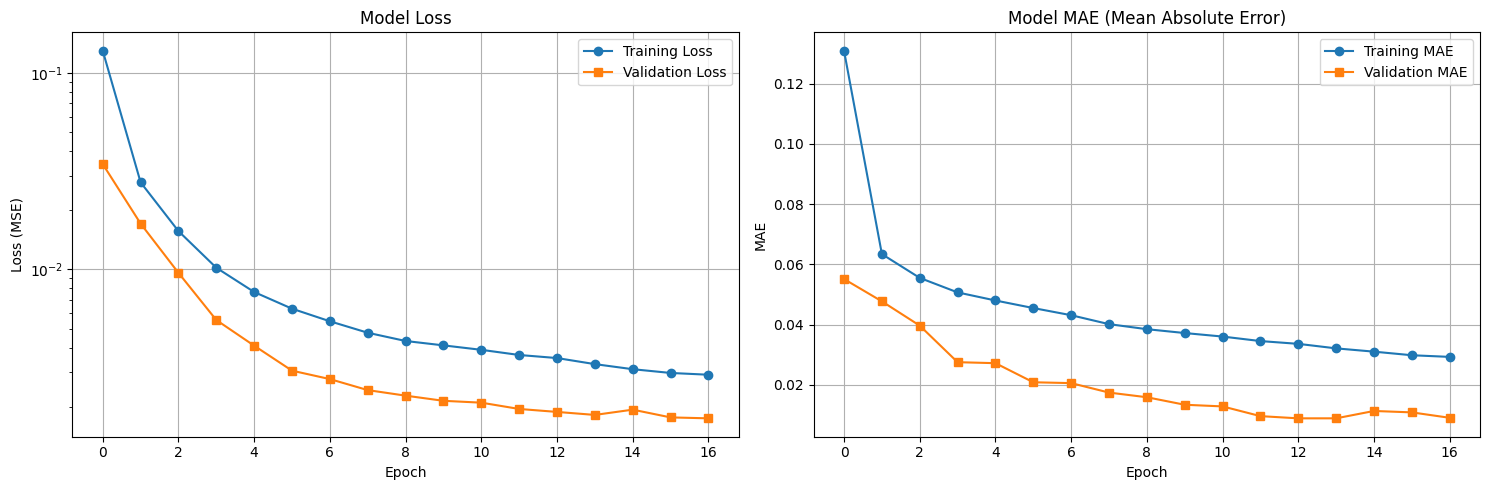


=== FINAL TRAINING METRICS ===
Final Training Loss: 0.002910
Final Validation Loss: 0.001745
Final Training MAE: 0.0293
Final Validation MAE: 0.0091

=== BEST PERFORMANCE ===
Best epoch: 17
Best validation loss: 0.001745
Best validation MAE: 0.0091

=== TRAINING INSIGHTS ===
Total epochs: 17
Early stopping triggered: No
✅ Good generalization - no overfitting


In [18]:
## Training Visualization
def plot_training_history(history):
    """
    Plot training history for single-output model
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plots
    axes[0].plot(history.history['loss'], label='Training Loss', marker='o')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='s')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_yscale('log')  # Log scale for better visualization

    # MAE plots
    axes[1].plot(history.history['mae'], label='Training MAE', marker='o')
    axes[1].plot(history.history['val_mae'], label='Validation MAE', marker='s')
    axes[1].set_title('Model MAE (Mean Absolute Error)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\n=== FINAL TRAINING METRICS ===")
    print(f"Final Training Loss: {history.history['loss'][-1]:.6f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.6f}")
    print(f"Final Training MAE: {history.history['mae'][-1]:.4f}")
    print(f"Final Validation MAE: {history.history['val_mae'][-1]:.4f}")

    # Find best epoch
    best_epoch = np.argmin(history.history['val_loss']) + 1
    best_val_loss = min(history.history['val_loss'])
    best_val_mae = history.history['val_mae'][best_epoch-1]

    print(f"\n=== BEST PERFORMANCE ===")
    print(f"Best epoch: {best_epoch}")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"Best validation MAE: {best_val_mae:.4f}")

    # Training insights
    print(f"\n=== TRAINING INSIGHTS ===")
    print(f"Total epochs: {len(history.history['loss'])}")
    print(f"Early stopping triggered: {'Yes' if len(history.history['loss']) < 15 else 'No'}")

    # Check for overfitting
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    if final_val_loss > final_train_loss * 1.5:
        print("⚠️  Potential overfitting detected")
    else:
        print("✅ Good generalization - no overfitting")

# Run the corrected visualization
plot_training_history(history)

In [20]:
## Hybrid Recommendation System Class
class HybridRecommendationSystem:
    def __init__(self, model, df, encoders):
        self.model = model
        self.df = df
        self.encoders = encoders

        # Since our model only outputs popularity, we'll use the hidden layer features
        self.content_representations = self._compute_all_representations()

    def _compute_all_representations(self):
        """Compute content representations using model's hidden layer"""
        print("Computing content representations for all items...")

        X_all = {
            'title_id': self.df['Title ID'].values.astype(np.int32),
            'language_id': self.df['Language Code'].values.astype(np.int32),
            'content_type': self.df['Content Type Code'].values.astype(np.int32),
            'release_season': self.df['Release Season'].values.astype(np.int32),
            'numerical_features': self.df[['Content Age', 'Is Global', 'Popularity Score',
                                          'Language Popularity', 'Type Popularity', 'Length Category']].values.astype(np.float32)
        }

        # Create a new model that outputs the hidden layer (before final prediction)
        # Get the second-to-last layer (before the final Dense(1) layer)
        representation_model = tf.keras.Model(
            inputs=self.model.input,
            outputs=self.model.layers[-2].output  # Get the layer before final output
        )

        # Get representations from the hidden layer
        representations = representation_model.predict(X_all, verbose=0, batch_size=256)
        print(f"Computed representations shape: {representations.shape}")
        return representations

    def recommend_similar(self, content_title, top_k=10, method='hybrid'):
        """
        Recommend similar content using different methods

        Args:
            content_title: Title to find recommendations for
            top_k: Number of recommendations
            method: 'content', 'collaborative', or 'hybrid'
        """
        # Find the content
        content_matches = self.df[self.df['Title'].str.contains(content_title, case=False, na=False)]

        if content_matches.empty:
            print(f"No content found matching '{content_title}'")
            # Show similar titles
            similar_titles = self.df[self.df['Title'].str.contains(' '.join(content_title.split()[:2]),
                                                                 case=False, na=False)]['Title'].head(5)
            if not similar_titles.empty:
                print("Did you mean one of these?")
                for title in similar_titles:
                    print(f"  - {title}")
            return None

        content_row = content_matches.iloc[0]
        content_idx = content_row.name

        print(f"Found: {content_row['Title']}")
        print(f"Language: {content_row['Language Indicator']}")
        print(f"Type: {content_row['Content Type']}")
        print(f"Hours Viewed: {content_row['Hours Viewed Clean']:,}")
        print(f"Popularity Score: {content_row['Popularity Score']:.3f}")
        print(f"Content Age: {content_row['Content Age']} years")

        if method == 'content':
            return self._content_based_recommendations(content_idx, top_k)
        elif method == 'collaborative':
            return self._collaborative_recommendations(content_idx, top_k)
        else:  # hybrid
            return self._hybrid_recommendations(content_idx, top_k)

    def _content_based_recommendations(self, content_idx, top_k):
        """Content-based recommendations using embeddings"""
        target_repr = self.content_representations[content_idx].reshape(1, -1)

        # Calculate cosine similarity with all other content
        similarities = cosine_similarity(target_repr, self.content_representations)[0]

        # Get top k similar items (excluding the item itself)
        similar_indices = np.argsort(similarities)[::-1][1:top_k+1]

        recommendations = self.df.iloc[similar_indices].copy()
        recommendations['Similarity Score'] = similarities[similar_indices]
        recommendations['Method'] = 'Content-Based'

        return recommendations[['Title', 'Language Indicator', 'Content Type',
                               'Hours Viewed Clean', 'Popularity Score', 'Similarity Score', 'Method']]

    def _collaborative_recommendations(self, content_idx, top_k):
        """Collaborative filtering recommendations using popularity and patterns"""
        content_row = self.df.iloc[content_idx]

        # Filter by similar characteristics
        same_type = self.df[self.df['Content Type Code'] == content_row['Content Type Code']]
        same_language = self.df[self.df['Language Code'] == content_row['Language Code']]

        # Combine and weight by popularity
        candidates = pd.concat([same_type, same_language]).drop_duplicates()
        candidates = candidates[candidates.index != content_idx]  # Exclude original

        # Sort by popularity and select top k
        recommendations = candidates.nlargest(top_k, 'Popularity Score').copy()
        recommendations['Similarity Score'] = recommendations['Popularity Score']
        recommendations['Method'] = 'Collaborative'

        return recommendations[['Title', 'Language Indicator', 'Content Type',
                               'Hours Viewed Clean', 'Popularity Score', 'Similarity Score', 'Method']]

    def _hybrid_recommendations(self, content_idx, top_k):
        """Hybrid recommendations combining content-based and collaborative filtering"""
        # Get content-based recommendations
        content_recs = self._content_based_recommendations(content_idx, top_k * 2)

        # Get collaborative recommendations
        collab_recs = self._collaborative_recommendations(content_idx, top_k * 2)

        # Combine recommendations with weighted scoring
        all_recommendations = []

        # Add content-based recommendations with weight
        if content_recs is not None and len(content_recs) > 0:
            for _, row in content_recs.iterrows():
                all_recommendations.append({
                    'Title': row['Title'],
                    'Language Indicator': row['Language Indicator'],
                    'Content Type': row['Content Type'],
                    'Hours Viewed Clean': row['Hours Viewed Clean'],
                    'Popularity Score': row['Popularity Score'],
                    'Content Score': row['Similarity Score'],
                    'Collab Score': 0,
                    'Hybrid Score': 0.6 * row['Similarity Score'],
                    'Method': 'Hybrid'
                })

        # Add collaborative recommendations
        if collab_recs is not None and len(collab_recs) > 0:
            for _, row in collab_recs.iterrows():
                # Check if already in recommendations
                existing = [r for r in all_recommendations if r['Title'] == row['Title']]
                if existing:
                    # Update existing recommendation
                    existing[0]['Collab Score'] = row['Similarity Score']
                    existing[0]['Hybrid Score'] = (0.6 * existing[0]['Content Score'] +
                                                 0.4 * row['Similarity Score'])
                else:
                    # Add new recommendation
                    all_recommendations.append({
                        'Title': row['Title'],
                        'Language Indicator': row['Language Indicator'],
                        'Content Type': row['Content Type'],
                        'Hours Viewed Clean': row['Hours Viewed Clean'],
                        'Popularity Score': row['Popularity Score'],
                        'Content Score': 0,
                        'Collab Score': row['Similarity Score'],
                        'Hybrid Score': 0.4 * row['Similarity Score'],
                        'Method': 'Hybrid'
                    })

        # Convert to DataFrame and sort by hybrid score
        if all_recommendations:
            recommendations_df = pd.DataFrame(all_recommendations)
            recommendations_df = recommendations_df.sort_values('Hybrid Score', ascending=False).head(top_k)
            return recommendations_df[['Title', 'Language Indicator', 'Content Type',
                                      'Hours Viewed Clean', 'Popularity Score', 'Hybrid Score', 'Method']]
        else:
            return pd.DataFrame()  # Return empty DataFrame if no recommendations

    def get_trending_recommendations(self, content_type=None, language=None, top_k=10):
        """Get trending recommendations based on popularity and recency"""
        filtered_df = self.df.copy()

        if content_type:
            filtered_df = filtered_df[filtered_df['Content Type'] == content_type]

        if language:
            filtered_df = filtered_df[filtered_df['Language Indicator'] == language]

        # Sort by popularity score and return top k
        trending = filtered_df.nlargest(top_k, 'Popularity Score')

        return trending[['Title', 'Language Indicator', 'Content Type',
                        'Hours Viewed Clean', 'Popularity Score', 'Content Age']]

    def search_titles(self, query, max_results=10):
        """Search for titles containing the query string"""
        matches = self.df[self.df['Title'].str.contains(query, case=False, na=False)]
        return matches[['Title', 'Language Indicator', 'Content Type',
                       'Hours Viewed Clean', 'Popularity Score']].head(max_results)

# Initialize the recommendation system
recommender = HybridRecommendationSystem(model, df, encoders)

print("\n=== HYBRID RECOMMENDATION SYSTEM READY ===")

Computing content representations for all items...
Computed representations shape: (19158, 16)

=== HYBRID RECOMMENDATION SYSTEM READY ===


In [21]:
## Testing the Recommendation System
def test_recommendation_system(recommender):
    """Test all recommendation methods"""

    print("\n" + "="*60)
    print("TESTING RECOMMENDATION SYSTEM")
    print("="*60)

    # Get some sample titles for testing
    sample_titles = df['Title'].head(5).tolist()
    print(f"Sample titles available for testing:")
    for i, title in enumerate(sample_titles, 1):
        print(f"{i}. {title}")

    # Test with first title
    test_title = sample_titles[0]
    print(f"\n{'='*60}")
    print(f"TESTING WITH: {test_title}")
    print(f"{'='*60}")

    print("\n--- CONTENT-BASED RECOMMENDATIONS ---")
    content_recs = recommender.recommend_similar(test_title, top_k=5, method='content')
    if content_recs is not None:
        print(content_recs.to_string(index=False))

    print("\n--- COLLABORATIVE FILTERING RECOMMENDATIONS ---")
    collab_recs = recommender.recommend_similar(test_title, top_k=5, method='collaborative')
    if collab_recs is not None:
        print(collab_recs.to_string(index=False))

    print("\n--- HYBRID RECOMMENDATIONS ---")
    hybrid_recs = recommender.recommend_similar(test_title, top_k=5, method='hybrid')
    if hybrid_recs is not None:
        print(hybrid_recs.to_string(index=False))

    print("\n--- TRENDING CONTENT ---")
    print("Top trending shows:")
    trending_shows = recommender.get_trending_recommendations(content_type='Show', top_k=5)
    print(trending_shows.to_string(index=False))

    print("\nTop trending movies:")
    trending_movies = recommender.get_trending_recommendations(content_type='Movie', top_k=5)
    print(trending_movies.to_string(index=False))

# Run tests
test_recommendation_system(recommender)


TESTING RECOMMENDATION SYSTEM
Sample titles available for testing:
1. The Night Agent: Season 1
2. Ginny & Georgia: Season 2
3. The Glory: Season 1 // 더 글로리: 시즌 1
4. Wednesday: Season 1
5. Queen Charlotte: A Bridgerton Story

TESTING WITH: The Night Agent: Season 1

--- CONTENT-BASED RECOMMENDATIONS ---
Found: The Night Agent: Season 1
Language: English
Type: Show
Hours Viewed: 812,100,000
Popularity Score: 1.000
Content Age: 0 years
                                    Title Language Indicator Content Type  Hours Viewed Clean  Popularity Score  Similarity Score        Method
                Ginny & Georgia: Season 2            English         Show           665100000          0.873291               1.0 Content-Based
                      ONE PIECE: Season 1            English         Show           541900000          0.767098               1.0 Content-Based
Physical: 100: Season 1 // 피지컬: 100: 시즌 1             Korean         Show           235000000          0.502561               1.0

In [22]:
print("🎬 TESTING WITH DIFFERENT CONTENT TYPES")
print("="*60)

# Test with a Movie
print("\n🎥 TESTING WITH A MOVIE:")
movie_recs = recommender.recommend_similar("Queen Charlotte", top_k=3, method='hybrid')
if movie_recs is not None and len(movie_recs) > 0:
    print(movie_recs[['Title', 'Content Type', 'Hybrid Score']].to_string(index=False))

# Test with Korean content
print("\n🇰🇷 TESTING WITH KOREAN CONTENT:")
korean_recs = recommender.recommend_similar("Glory", top_k=3, method='hybrid')
if korean_recs is not None and len(korean_recs) > 0:
    print(korean_recs[['Title', 'Language Indicator', 'Hybrid Score']].to_string(index=False))

# Test search functionality
print("\n🔍 SEARCH TESTS:")
search_terms = ["Wednesday", "Money", "Agent"]
for term in search_terms:
    print(f"\nSearching for '{term}':")
    results = recommender.search_titles(term, max_results=2)
    if len(results) > 0:
        print(results[['Title', 'Content Type', 'Popularity Score']].to_string(index=False))
    else:
        print("No results found")

# Test trending by language
print("\n🌍 TRENDING BY LANGUAGE:")
print("\nTrending English Content:")
trending_en = recommender.get_trending_recommendations(language='English', top_k=3)
print(trending_en[['Title', 'Content Type', 'Popularity Score']].to_string(index=False))

print("\nTrending Korean Content:")
trending_kr = recommender.get_trending_recommendations(language='Korean', top_k=3)
print(trending_kr[['Title', 'Content Type', 'Popularity Score']].to_string(index=False))

🎬 TESTING WITH DIFFERENT CONTENT TYPES

🎥 TESTING WITH A MOVIE:
Found: Queen Charlotte: A Bridgerton Story
Language: English
Type: Movie
Hours Viewed: 503,000,000
Popularity Score: 0.734
Content Age: 0 years
                                                      Title Content Type  Hybrid Score
Crash Course in Romance: Limited Series // 일타 스캔들: 리미티드 시리즈        Movie           0.6
                        Queen Charlotte: A Bridgerton Story        Movie           0.6
 Strong Girl Nam-soon: Limited Series // 힘쎈여자 강남순: 리미티드 시리즈        Movie           0.6

🇰🇷 TESTING WITH KOREAN CONTENT:
Found: The Glory: Season 1 // 더 글로리: 시즌 1
Language: Korean
Type: Show
Hours Viewed: 622,800,000
Popularity Score: 0.687
Content Age: 1 years
                                                    Title Language Indicator  Hybrid Score
                                      Wednesday: Season 1            English      0.599984
Extraordinary Attorney Woo: Season 1 // 이상한 변호사 우영우: 시즌 1             Korean      0.5999

In [27]:
## Model Evaluation and Quality Metrics
def detailed_evaluation(recommender, sample_size=50):
    """
    More comprehensive evaluation with detailed analysis
    """
    print("🔍 DETAILED RECOMMENDATION QUALITY EVALUATION")
    print("="*60)

    # Get a good mix of content for testing
    popular_content = df.nlargest(20, 'Popularity Score')
    medium_content = df.nmedian(20, 'Popularity Score') if hasattr(df, 'nmedian') else df.sample(20)
    random_content = df.sample(10)

    test_content = pd.concat([popular_content, medium_content, random_content]).drop_duplicates()
    sample_indices = test_content.index[:sample_size]

    metrics = {
        'content_diversity': [],
        'language_diversity': [],
        'popularity_scores': [],
        'content_type_consistency': [],
        'recommendation_counts': [],
        'avg_similarity_scores': []
    }

    successful_tests = 0

    for idx in sample_indices:
        content_title = df.iloc[idx]['Title']
        original_type = df.iloc[idx]['Content Type']
        original_popularity = df.iloc[idx]['Popularity Score']

        try:
            # Test hybrid recommendations
            recs = recommender.recommend_similar(content_title, top_k=5, method='hybrid')

            if recs is not None and len(recs) > 0:
                successful_tests += 1

                # Content diversity
                unique_types = len(recs['Content Type'].unique())
                content_diversity = unique_types / len(recs)
                metrics['content_diversity'].append(content_diversity)

                # Language diversity
                unique_languages = len(recs['Language Indicator'].unique())
                language_diversity = unique_languages / len(recs)
                metrics['language_diversity'].append(language_diversity)

                # Popularity analysis
                avg_popularity = recs['Popularity Score'].mean()
                metrics['popularity_scores'].append(avg_popularity)

                # Content type consistency
                same_type_count = (recs['Content Type'] == original_type).sum()
                type_consistency = same_type_count / len(recs)
                metrics['content_type_consistency'].append(type_consistency)

                # Additional metrics
                metrics['recommendation_counts'].append(len(recs))

                if 'Hybrid Score' in recs.columns:
                    avg_score = recs['Hybrid Score'].mean()
                    metrics['avg_similarity_scores'].append(avg_score)

                # Print sample for first few
                if successful_tests <= 3:
                    print(f"\nSample {successful_tests}: {content_title[:40]}...")
                    print(f"Original popularity: {original_popularity:.3f}")
                    print(f"Recommended content types: {recs['Content Type'].unique()}")
                    print(f"Recommended languages: {recs['Language Indicator'].unique()}")
                    print(f"Avg recommended popularity: {avg_popularity:.3f}")

        except Exception as e:
            print(f"Error testing {content_title}: {e}")
            continue

    # Calculate final metrics
    if successful_tests > 0:
        print(f"\n📊 EVALUATION RESULTS (based on {successful_tests} successful tests):")
        print("="*60)
        print(f"Content Diversity: {np.mean(metrics['content_diversity']):.3f} (higher is better)")
        print(f"Language Diversity: {np.mean(metrics['language_diversity']):.3f}")
        print(f"Average Popularity Score: {np.mean(metrics['popularity_scores']):.3f}")
        print(f"Content Type Consistency: {np.mean(metrics['content_type_consistency']):.3f}")

        if metrics['avg_similarity_scores']:
            print(f"Average Hybrid Score: {np.mean(metrics['avg_similarity_scores']):.3f}")

        # Distribution analysis
        print(f"\n📈 DISTRIBUTION ANALYSIS:")
        print(f"Popularity score range: {np.min(metrics['popularity_scores']):.3f} - {np.max(metrics['popularity_scores']):.3f}")
        print(f"Content diversity range: {np.min(metrics['content_diversity']):.3f} - {np.max(metrics['content_diversity']):.3f}")
        print(f"Language diversity range: {np.min(metrics['language_diversity']):.3f} - {np.max(metrics['language_diversity']):.3f}")

        # Quality assessment
        print(f"\n✅ QUALITY ASSESSMENT:")
        good_diversity = np.mean(metrics['content_diversity']) > 0.4
        good_popularity = np.mean(metrics['popularity_scores']) > 0.3
        good_consistency = np.mean(metrics['content_type_consistency']) > 0.6

        print(f"Content Diversity: {'✅ Good' if good_diversity else '⚠️ Needs Improvement'}")
        print(f"Popularity Balance: {'✅ Good' if good_popularity else '⚠️ Low - recommending niche content'}")
        print(f"Type Consistency: {'✅ Good' if good_consistency else '⚠️ Too random'}")

    else:
        print("❌ No successful tests completed")

# Run comprehensive evaluation
detailed_evaluation(recommender, sample_size=30)

🔍 DETAILED RECOMMENDATION QUALITY EVALUATION
Found: The Night Agent: Season 1
Language: English
Type: Show
Hours Viewed: 812,100,000
Popularity Score: 1.000
Content Age: 0 years

Sample 1: The Night Agent: Season 1...
Original popularity: 1.000
Recommended content types: ['Show']
Recommended languages: ['English' 'Korean']
Avg recommended popularity: 0.694
Found: Ginny & Georgia: Season 2
Language: English
Type: Show
Hours Viewed: 665,100,000
Popularity Score: 0.873
Content Age: 0 years

Sample 2: Ginny & Georgia: Season 2...
Original popularity: 0.873
Recommended content types: ['Show']
Recommended languages: ['English' 'Korean']
Avg recommended popularity: 0.675
Found: ONE PIECE: Season 1
Language: English
Type: Show
Hours Viewed: 541,900,000
Popularity Score: 0.767
Content Age: 0 years

Sample 3: ONE PIECE: Season 1...
Original popularity: 0.767
Recommended content types: ['Show']
Recommended languages: ['English' 'Korean']
Avg recommended popularity: 0.665
Found: Queen Charlotte: A

In [25]:
## Save Model and Components
def save_model_components():
    """Save all model components for deployment"""
    print("\n" + "="*60)
    print("SAVING MODEL COMPONENTS")
    print("="*60)

    # Save the trained model
    model.save('netflix_hybrid_recommender.h5')
    print("✓ Hybrid model saved as 'netflix_hybrid_recommender.h5'")

    # Save the processed dataframe
    df.to_csv('processed_netflix_hybrid.csv', index=False)
    print("✓ Processed data saved as 'processed_netflix_hybrid.csv'")

    # Save precomputed representations
    np.save('content_representations.npy', recommender.content_representations)
    print("✓ Content representations saved as 'content_representations.npy'")

    # Save all metadata and encoders
    metadata = {
        'num_titles': df['Title ID'].nunique(),
        'num_languages': df['Language Code'].nunique(),
        'num_types': df['Content Type Code'].nunique(),
        'num_seasons': df['Release Season'].nunique(),
        'language_encoder': encoders['language_encoder'],
        'content_type_encoder': encoders['content_type_encoder'],
        'scaler': encoders['scaler'],
        'feature_scaler': encoders['feature_scaler'],
        'language_categories': dict(enumerate(encoders['language_encoder'].classes_)),
        'type_categories': dict(enumerate(encoders['content_type_encoder'].classes_)),
        'feature_columns': ['Content Age', 'Is Global', 'Popularity Score',
                           'Language Popularity', 'Type Popularity', 'Length Category']
    }

    with open('hybrid_model_metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)
    print("✓ Model metadata saved as 'hybrid_model_metadata.pkl'")

    # Save training history
    with open('training_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    print("✓ Training history saved as 'training_history.pkl'")

    # Download files if in Colab
    if IN_COLAB:
        print("\nDownloading files...")
        files.download('netflix_hybrid_recommender.h5')
        files.download('processed_netflix_hybrid.csv')
        files.download('content_representations.npy')
        files.download('hybrid_model_metadata.pkl')
        files.download('training_history.pkl')
        print("✓ All files downloaded successfully!")

    print(f"\n✓ All components saved successfully!")
    print("\nFiles generated:")
    print("- netflix_hybrid_recommender.h5 (trained model)")
    print("- processed_netflix_hybrid.csv (processed dataset)")
    print("- content_representations.npy (precomputed embeddings)")
    print("- hybrid_model_metadata.pkl (encoders and metadata)")
    print("- training_history.pkl (training metrics)")

save_model_components()


SAVING MODEL COMPONENTS
✓ Hybrid model saved as 'netflix_hybrid_recommender.h5'
✓ Processed data saved as 'processed_netflix_hybrid.csv'
✓ Content representations saved as 'content_representations.npy'
✓ Model metadata saved as 'hybrid_model_metadata.pkl'
✓ Training history saved as 'training_history.pkl'



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ All files downloaded successfully!

✓ All components saved successfully!

Files generated:
- netflix_hybrid_recommender.h5 (trained model)
- processed_netflix_hybrid.csv (processed dataset)
- content_representations.npy (precomputed embeddings)
- hybrid_model_metadata.pkl (encoders and metadata)
- training_history.pkl (training metrics)
